In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import os
import sys

ROOT = os.path.dirname(os.getcwd())
sys.path.append(ROOT)
ROOT

'/Users/louisecolumelli/Documents/karl/RL-solitaire/rl-solitaire'

In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
from pytorch_lightning import seed_everything
import torch

from utils.tools import load_pickle, read_yaml
from env.env import Env

In [5]:
AGENT_NAME = 'actor_critic'
NETWORK_NAME = 'fc_policy_value'
RUN_NAME = '2024_02_16-16_24' # '2024_02_16-14_13'
SEED = 42

run_dir = os.path.join(ROOT, 'agents', AGENT_NAME, 'runs', RUN_NAME)
network_config_filename = f"{AGENT_NAME}_config.yaml"
seed_everything(seed=SEED)

Seed set to 42


42

In [34]:
results_path = os.path.join(run_dir, 'agent_results.pickle')
all_results = load_pickle(results_path, single=False)

In [35]:
len(all_results)

4000

In [36]:
reward_means = []
reward_stds = []
pegs_means = []
pegs_stds = []
for i in range(len(all_results)):
    results_i = all_results[i]
    rewards = results_i["rewards"]
    pegs_left = results_i["pegs_left"]

    reward_means.append(np.mean(rewards))
    reward_stds.append(np.std(rewards))

    pegs_means.append(np.mean(pegs_left))
    pegs_stds.append(np.std(pegs_left))

reward_means = np.array(reward_means)
reward_stds = np.array(reward_stds)
pegs_means = np.array(pegs_means)
pegs_stds = np.array(pegs_stds)

# Agent Results

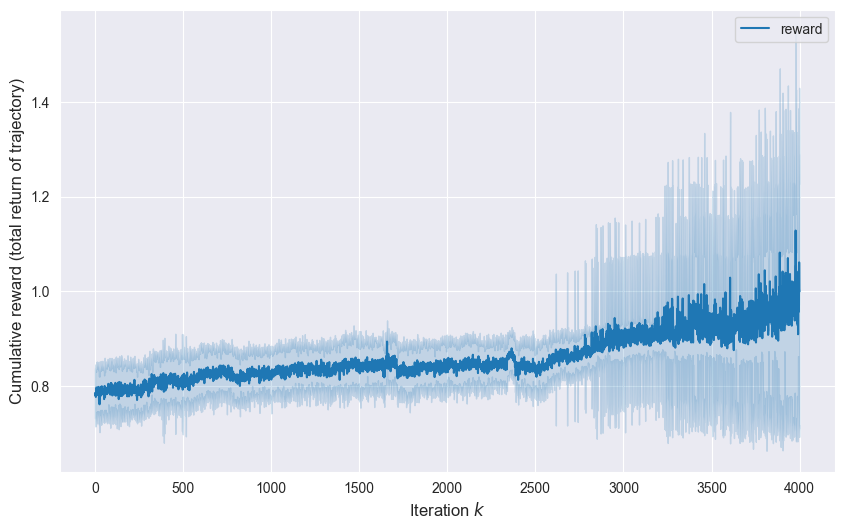

In [37]:
figsize = (10, 6)
scale = 1.0
fontsize = 12
color = sns.color_palette()[0]

plt.figure(figsize=figsize)
iteration_number = np.arange(len(reward_means))
plt.plot(iteration_number, reward_means, label='reward', color=color)
plt.fill_between(iteration_number, reward_means - scale * reward_stds, reward_means + scale * reward_stds, color=color, alpha = 0.2)
plt.xlabel('Iteration $k$', fontsize=fontsize)
plt.ylabel('Cumulative reward (total return of trajectory)', fontsize=fontsize)
plt.legend()
plt.show()

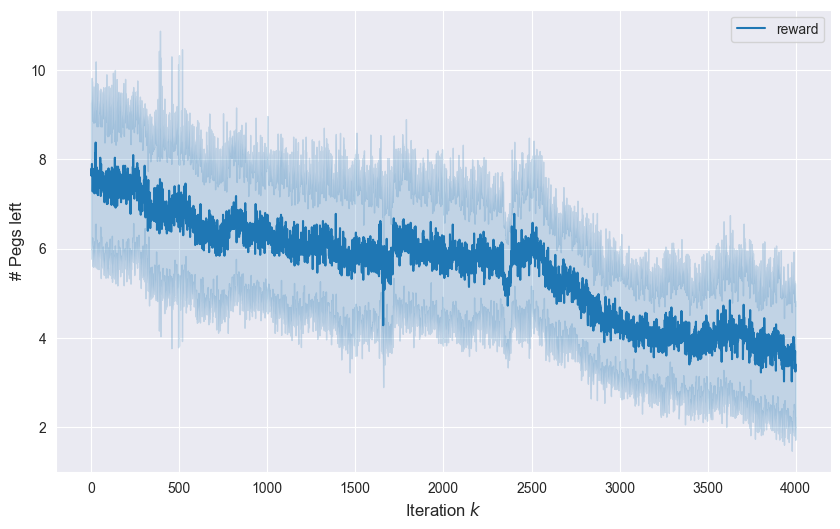

In [38]:
figsize = (10, 6)
scale = 1.0
fontsize = 12
color = sns.color_palette()[0]

plt.figure(figsize=figsize)
iteration_number = np.arange(len(pegs_means))
plt.plot(iteration_number, pegs_means, label='reward', color=color)
plt.fill_between(iteration_number, pegs_means - scale * pegs_stds, pegs_means + scale * pegs_stds, color=color, alpha = 0.2)
plt.xlabel('Iteration $k$', fontsize=fontsize)
plt.ylabel('# Pegs left', fontsize=fontsize)
plt.legend()
plt.show()

In [39]:
np.min(pegs_means)

3.02

In [40]:
np.max(reward_means)

1.1283870967741931

In [41]:
np.argmax(reward_means)

3977

In [42]:
all_rewards = [r for res in all_results for r in res['rewards']]
print(len(all_rewards))
print(np.max(all_rewards))
print(np.min(all_rewards))

200000
1.9677419354838703
0.1935483870967742


In [43]:
all_pegs = [r for res in all_results for r in res['pegs_left']]
print(len(all_pegs))
print(np.max(all_pegs))
print(np.min(all_pegs))

200000
26
1


In [44]:
os.listdir(path=os.path.join(run_dir, 'checkpoints'))

['epoch=2101_step=16820',
 'epoch=3301_step=26999',
 'epoch=3901_step=32399',
 'epoch=1801_step=14415',
 'epoch=2701_step=21677',
 'epoch=3989_step=33200.ckpt',
 'epoch=1201_step=9605',
 'epoch=901_step=7205',
 'epoch=2401_step=19237',
 'epoch=3601_step=29699',
 'epoch=1501_step=12008',
 'epoch=4000_step=33290',
 'epoch=301_step=2405',
 'epoch=601_step=4805',
 'epoch=1_step=8',
 'epoch=3001_step=24299']

In [46]:
checkpoint_name = 'epoch=4000_step=33290'

# Load and evaluate agent from checkpoint

In [47]:
from agents.actor_critic.actor_critic_agent import ActorCriticAgent
from nn.policy_value.fully_connected import FCPolicyValueNet
from nn.network_config import NetConfig

In [48]:
# set and net config
network_config_filename = f"{NETWORK_NAME}_config.yaml"
network_config_dict = read_yaml(os.path.join(run_dir, network_config_filename))

network_config = NetConfig(config_dict=network_config_dict)
#network = FCPolicyValueNet(network_config)

In [49]:
checkpoint_path = os.path.join(run_dir, 'checkpoints', checkpoint_name)
network = FCPolicyValueNet.load_from_checkpoint(checkpoint_path, config=network_config)

In [50]:
agent_name = f"ActorCriticAgent-{network.name}"
agent = ActorCriticAgent(network=network, name=agent_name)

In [51]:
n_games_eval = 1000
agent.set_evaluation_mode()
env = Env()
env.reset()

with torch.no_grad():
    rewards, pegs_left = agent.evaluate(env, n_games=n_games_eval, greedy=False)
    greedy_reward, greedy_pegs = agent.evaluate(env, greedy=True)
    greedy_reward = greedy_reward[0]
    greedy_pegs = greedy_pegs[0]

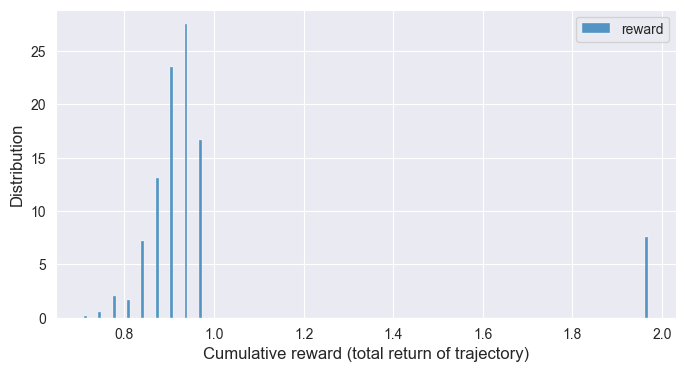

In [52]:
figsize = (8, 4)
scale = 1.0
fontsize = 12

plt.figure(figsize=figsize)
#sns.histplot(data=rewards, stat='probability')
sns.histplot(data=rewards, stat='percent', label='reward')

plt.xlabel('Cumulative reward (total return of trajectory)', fontsize=fontsize)
plt.ylabel('Distribution', fontsize=fontsize)
plt.legend()
plt.show()


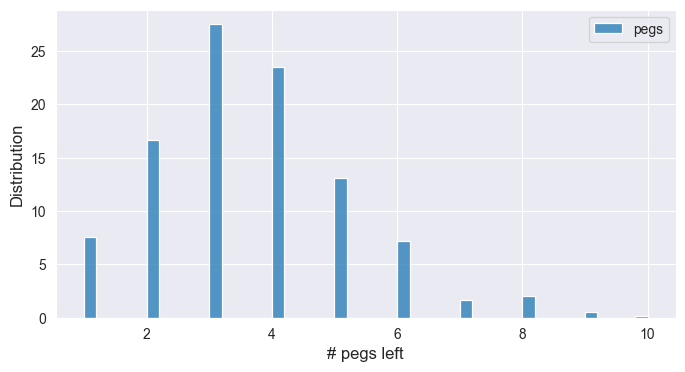

In [53]:
figsize = (8, 4)
scale = 1.0
fontsize = 12

plt.figure(figsize=figsize)
#sns.histplot(data=rewards, stat='probability')
sns.histplot(data=pegs_left, stat='percent', label='pegs')
# sns.histplot(data=pegs_left, stat='percent', label='pegs', bins=12)

plt.xlabel('# pegs left', fontsize=fontsize)
plt.ylabel('Distribution', fontsize=fontsize)
plt.legend()
plt.show()


In [54]:
print(np.mean(rewards))
print(np.mean(pegs_left))

0.9894838709677414
3.606


In [55]:
print(greedy_reward)
print(greedy_pegs)

0.9677419354838703
2
